# Horizon plots of ILS proportions

In [2]:
%matplotlib inline

%env http_proxy=http://proxy-default:3128
%env https_proxy=http://proxy-default:3128

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import warnings
from scipy import signal, stats
from statsmodels.nonparametric.smoothers_lowess import lowess

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import sklearn
from sklearn.preprocessing import quantile_transform

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D


import mpld3

from horizonplot import horizonplot
from chromwindow import window

import seaborn as sns
sns.set()
sns.set_style("ticks")
sns.set_context("notebook")

# scale down size of default plots
import matplotlib as mpl
scale = 1
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
mpl.rcParams.update(d)

def add_band(x_low, x_high, y_low=None, y_high=None, ax=None, color='gray', linewidth=0, alpha=0.5, zorder=0, **kwargs):
    "Plot a gray block on x interval"
    if ax is None:
        ax = plt.gca()
    if y_low is None:
        y_low, _ = ax.get_ylim()
    if y_high is None:
        _, y_high = ax.get_ylim()
    g = ax.add_patch(Rectangle((x_low, y_low), x_high-x_low, y_high-y_low, 
                 facecolor=color,
                 linewidth=linewidth,
                 alpha=alpha,
                 zorder=zorder,
                 **kwargs))

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

# My own paired palette replacing the last brown pair with violets
sns.color_palette('Paired').as_hex()
Paired = sns.color_palette(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c',
                            '#fdbf6f', '#ff7f00', '#cab2d6','#6a3d9a', '#e585cf', '#ad009d'])
#sns.palplot(Paired)
Infographics = sns.color_palette(['#e8615d', '#f49436', '#2d9de5', '#3bbdbd', '#634792'])
#sns.palplot(Infographics)

chromosomes = list(map(str, range(1,23))) + ['X']

## Load ILS data

In [3]:
ils_data = pd.read_hdf('../steps/merge_ils_data/merged_ils_data.h5')
ils_data['chrom'] = ils_data['chrom'].astype(str)

ils_data['tot_segment'] = ils_data[['V0', 'V1', 'V2', 'V3']].sum(axis=1)
ils_data['propils'] = ils_data[['V2', 'V3']].sum(axis=1) / ils_data.tot_segment
ils_data['ilsskew'] = (ils_data.V2 - ils_data.V3) / (ils_data.V2 + ils_data.V3)

# mask windwos with too few analysed bases
# mask = ils_data.tot_segment < 30000
mask = ils_data.tot_segment < 10000
ils_data.loc[mask, 'propils'] = np.nan
ils_data.loc[mask, 'ilsskew'] = np.nan

# def zscore(sr):
#     return (sr - sr.mean()) / sr.std()

# gr = ils_data.groupby(['chrom', 'analysis'])
# ils_data['propils_z_score'] = gr.propils.transform(zscore)
# ils_data['ilsskew_z_score'] = gr.ilsskew.transform(zscore)

ils_data.head()

,chrom,start,end,analysis,V0,V1,V2,V3,tot_segment,propils,ilsskew
0,1,0,100000,AOTNAN_SAGMID_CEBALB_HOMSAP,15713,6197,9257,4414,35581,0.384222,0.354254
1,1,100000,200000,AOTNAN_SAGMID_CEBALB_HOMSAP,27899,8485,21983,14441,72808,0.500275,0.207061
2,1,200000,300000,AOTNAN_SAGMID_CEBALB_HOMSAP,14114,4976,7714,4483,31287,0.389842,0.264901
3,1,300000,400000,AOTNAN_SAGMID_CEBALB_HOMSAP,10287,1161,7339,7719,26506,0.568098,-0.025236
4,1,400000,500000,AOTNAN_SAGMID_CEBALB_HOMSAP,15683,1854,11097,6801,35435,0.505094,0.240027


## Transformations

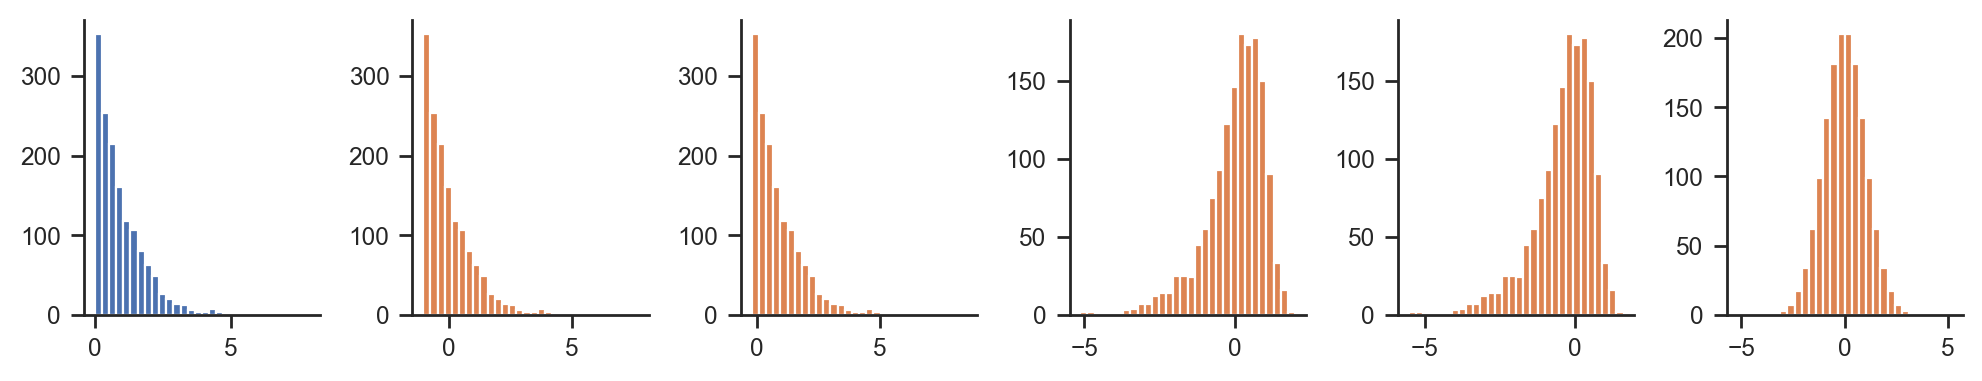

In [4]:
rng = np.random.default_rng()
ils = rng.exponential(scale=1, size=1500)

def z_transform(x):
    return (x - x.mean()) / x.std()

def z_mode_transform(x, nrbins=20):
    if type(x) is pd.core.series.Series:
        x = x.to_numpy()
    y = np.squeeze(x)    
    vals, bins = np.histogram(y[~np.isnan(y)], bins=nrbins)
    idx = np.argmax(vals)
    mode = bins[idx] + (bins[idx+1] - bins[idx]) / 2
    return (y - mode) / np.nanstd(y)

def log_z_transform(x):
    if type(x) is pd.core.series.Series:
        x = x.to_numpy()
    x = np.squeeze(x)    
    x = x + np.nanmin(x[np.nonzero(x)]) / 2
    y = np.log(x)
    return (y - np.nanmean(y)) / np.nanstd(y)

def log_z_mode_transform(x, nrbins=20):
    if type(x) is pd.core.series.Series:
        x = x.to_numpy()
    x = np.squeeze(x)    
    x = x + np.nanmin(x[np.nonzero(x)]) / 2
    y = np.log(x)
    vals, bins = np.histogram(y[~np.isnan(y)], bins=nrbins)
    idx = np.argmax(vals)
    mode = bins[idx] + (bins[idx+1] - bins[idx]) / 2
    return (y - mode) / np.nanstd(y)

def quantile_norm(x):
    if type(x) is pd.core.series.Series:
        x = x.to_numpy()
    x = np.squeeze(x)
    rng = np.random.default_rng()
    trans = quantile_transform(np.reshape(x, (x.shape[0], 1)), n_quantiles=len(x), 
                                random_state=0, copy=True, output_distribution='normal')
    return np.squeeze(trans)

fig, ax = plt.subplots(1, 6, figsize=(10, 2))
nrbins=30
ax[0].hist(ils, bins=nrbins);
ax[1].hist(z_transform(ils), bins=nrbins, color='C1');
ax[2].hist(z_mode_transform(ils), bins=nrbins, color='C1');
ax[3].hist(log_z_transform(ils), bins=nrbins, color='C1');
ax[4].hist(log_z_mode_transform(ils), bins=nrbins, color='C1');
ax[5].hist(quantile_norm(ils), bins=nrbins, color='C1');
plt.tight_layout()
sns.despine()

Transforms for ILS proportion:

In [5]:
grouped = ils_data.groupby(['chrom', 'analysis'])['propils']
ils_data['propils_qnorm'] = grouped.transform(quantile_norm)
ils_data['propils_znorm'] = grouped.transform(z_transform)
ils_data['propils_logznorm'] = grouped.transform(log_z_transform)
ils_data['propils_logzmodenorm'] = grouped.transform(log_z_mode_transform)

Transforms for ILS skew:

In [6]:
grouped = ils_data.groupby(['chrom', 'analysis'])['ilsskew']
ils_data['ilsskew_qnorm'] = grouped.transform(quantile_norm)
ils_data['ilsskew_znorm'] = grouped.transform(z_transform)
ils_data['ilsskew_zmodenorm'] = grouped.transform(z_mode_transform)

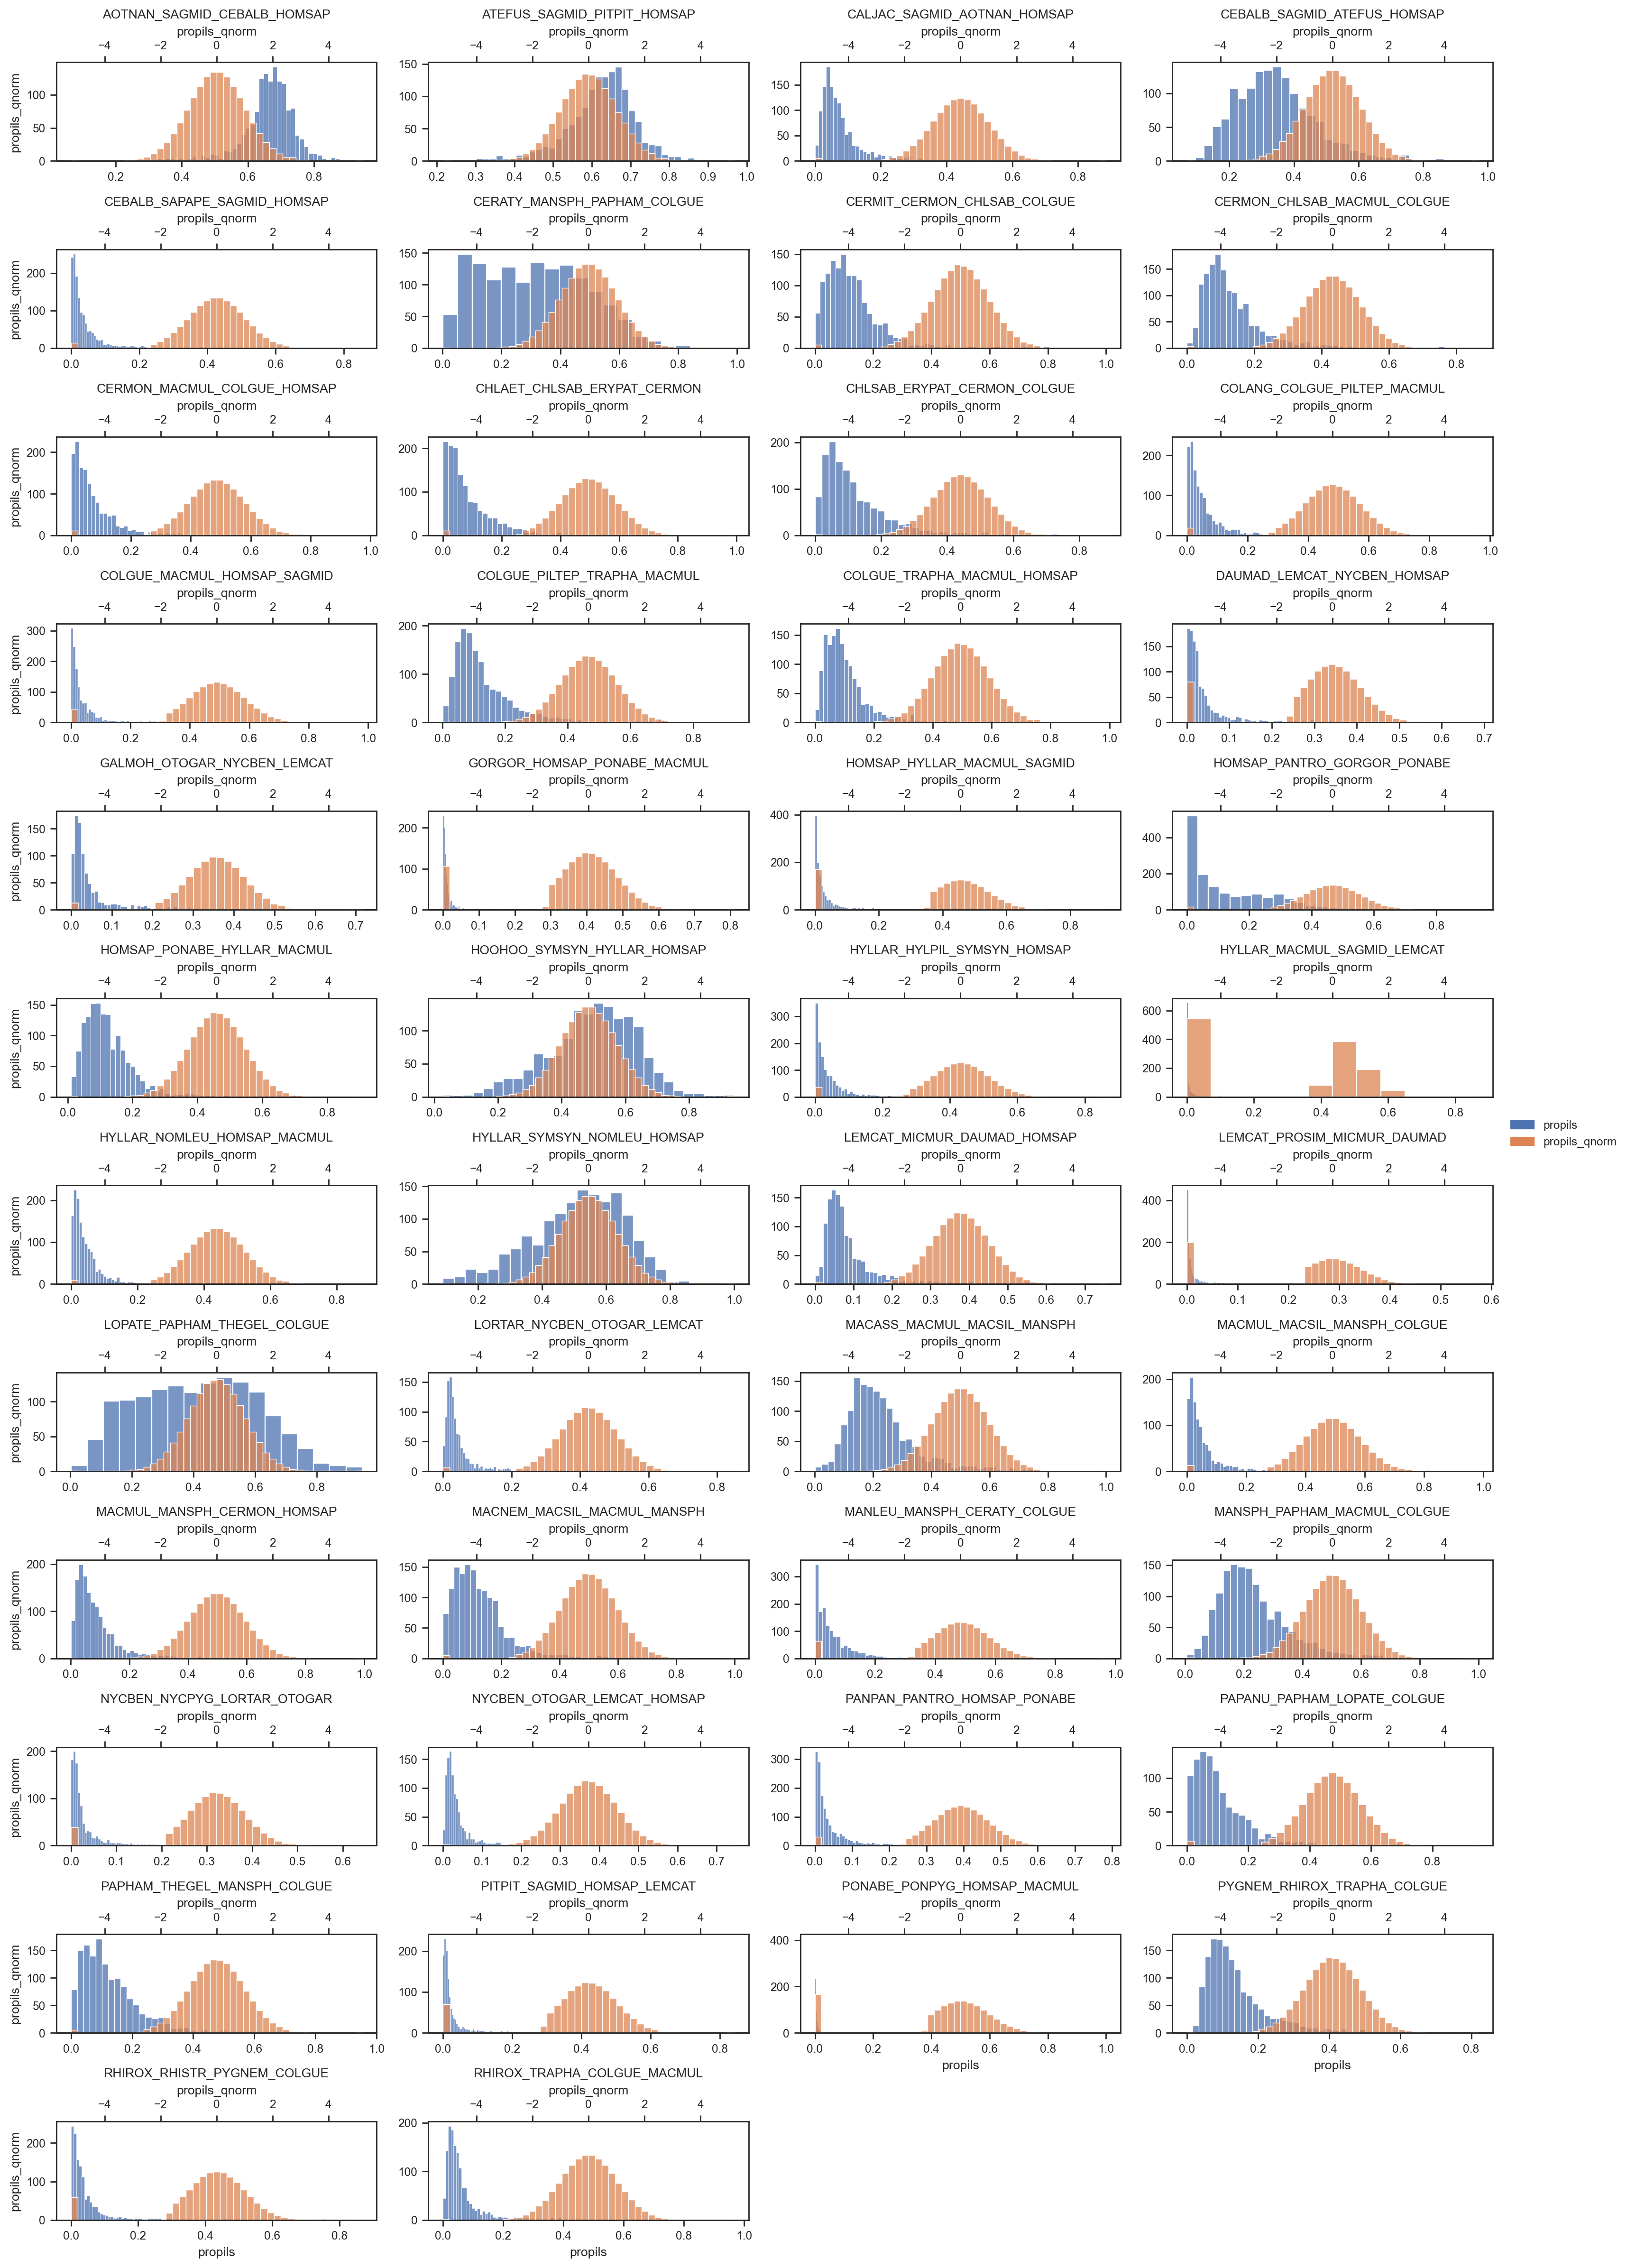

In [7]:
variables = ['propils', 'propils_qnorm']

plot_df = ils_data.loc[ils_data.chrom == 'X', ['analysis']+variables]#.head(10000)
g = sns.FacetGrid(data=plot_df, col='analysis', height=2, aspect=2, col_wrap=4, sharey=False, sharex=False)

def plot(x1, x2, data=None, color=None, label=None):
    sns.histplot(data, x=x1, label=x1)
    sns.histplot(data, x=x2, color='C1', label=x2, ax=plt.gca().twiny())
    
g.map_dataframe(plot, *variables)
g.set_titles("{col_name}")

# g.add_legend(legend_data=dict(zip(g._legend_data.keys(), g._legend_data.values())))
# g.add_legend(legend_data=dict(zip(['proportion of ils'], g._legend_data.values())))
g.add_legend(legend_data=dict(zip(variables, [Patch(color='C0'), Patch(color='C1')])))

## Add species names

Add species names from mapping between analysis labels and names of included species:

In [69]:
name_mapping = pd.read_csv('/home/kmt/Primategenomes/data/mapping_names.csv', header=0, names=['names', 'analysis'])
ils_data = ils_data.merge(name_mapping, on='analysis')
ils_data.head()

,chrom,start,end,analysis,V0,V1,V2,V3,tot_segment,propils,ilsskew,propils_logznorm,propils_logzmodenorm,propils_qnorm,propils_znorm,ilsskew_qnorm,ilsskew_znorm,ilsskew_logznorm,ilsskew_zmodenorm,names
0,1,0,100000,AOTNAN_SAGMID_CEBALB_HOMSAP,15713,6197,9257,4414,35581,0.384222,0.354254,-4.562875,-4.839088,-2.510618,-4.032554,0.371906,0.325882,-0.198956,0.283385,Aotus_nancymaae Saguinus_midas Cebus_albifrons...
1,1,100000,200000,AOTNAN_SAGMID_CEBALB_HOMSAP,27899,8485,21983,14441,72808,0.500275,0.207061,-2.292568,-2.568780,-1.891036,-2.273812,-0.809231,-0.642302,NaN,-0.685014,Aotus_nancymaae Saguinus_midas Cebus_albifrons...
2,1,200000,300000,AOTNAN_SAGMID_CEBALB_HOMSAP,14114,4976,7714,4483,31287,0.389842,0.264901,-4.440396,-4.716609,-2.433407,-3.947377,-0.368784,-0.261849,NaN,-0.304477,Aotus_nancymaae Saguinus_midas Cebus_albifrons...
3,1,300000,400000,AOTNAN_SAGMID_CEBALB_HOMSAP,10287,1161,7339,7719,26506,0.568098,-0.025236,-1.168320,-1.444533,-1.427019,-1.245975,-2.009402,-2.170279,NaN,-2.213330,Aotus_nancymaae Saguinus_midas Cebus_albifrons...
4,1,400000,500000,AOTNAN_SAGMID_CEBALB_HOMSAP,15683,1854,11097,6801,35435,0.505094,0.240027,-2.208442,-2.484655,-1.857263,-2.200779,-0.566879,-0.425465,NaN,-0.468129,Aotus_nancymaae Saguinus_midas Cebus_albifrons...


Write to HDF for use in other notebooks:

In [70]:
ils_data.to_hdf('../results/ils_data.h5', 'df', format='table', mode='w')

## Global ILS proportion in each species

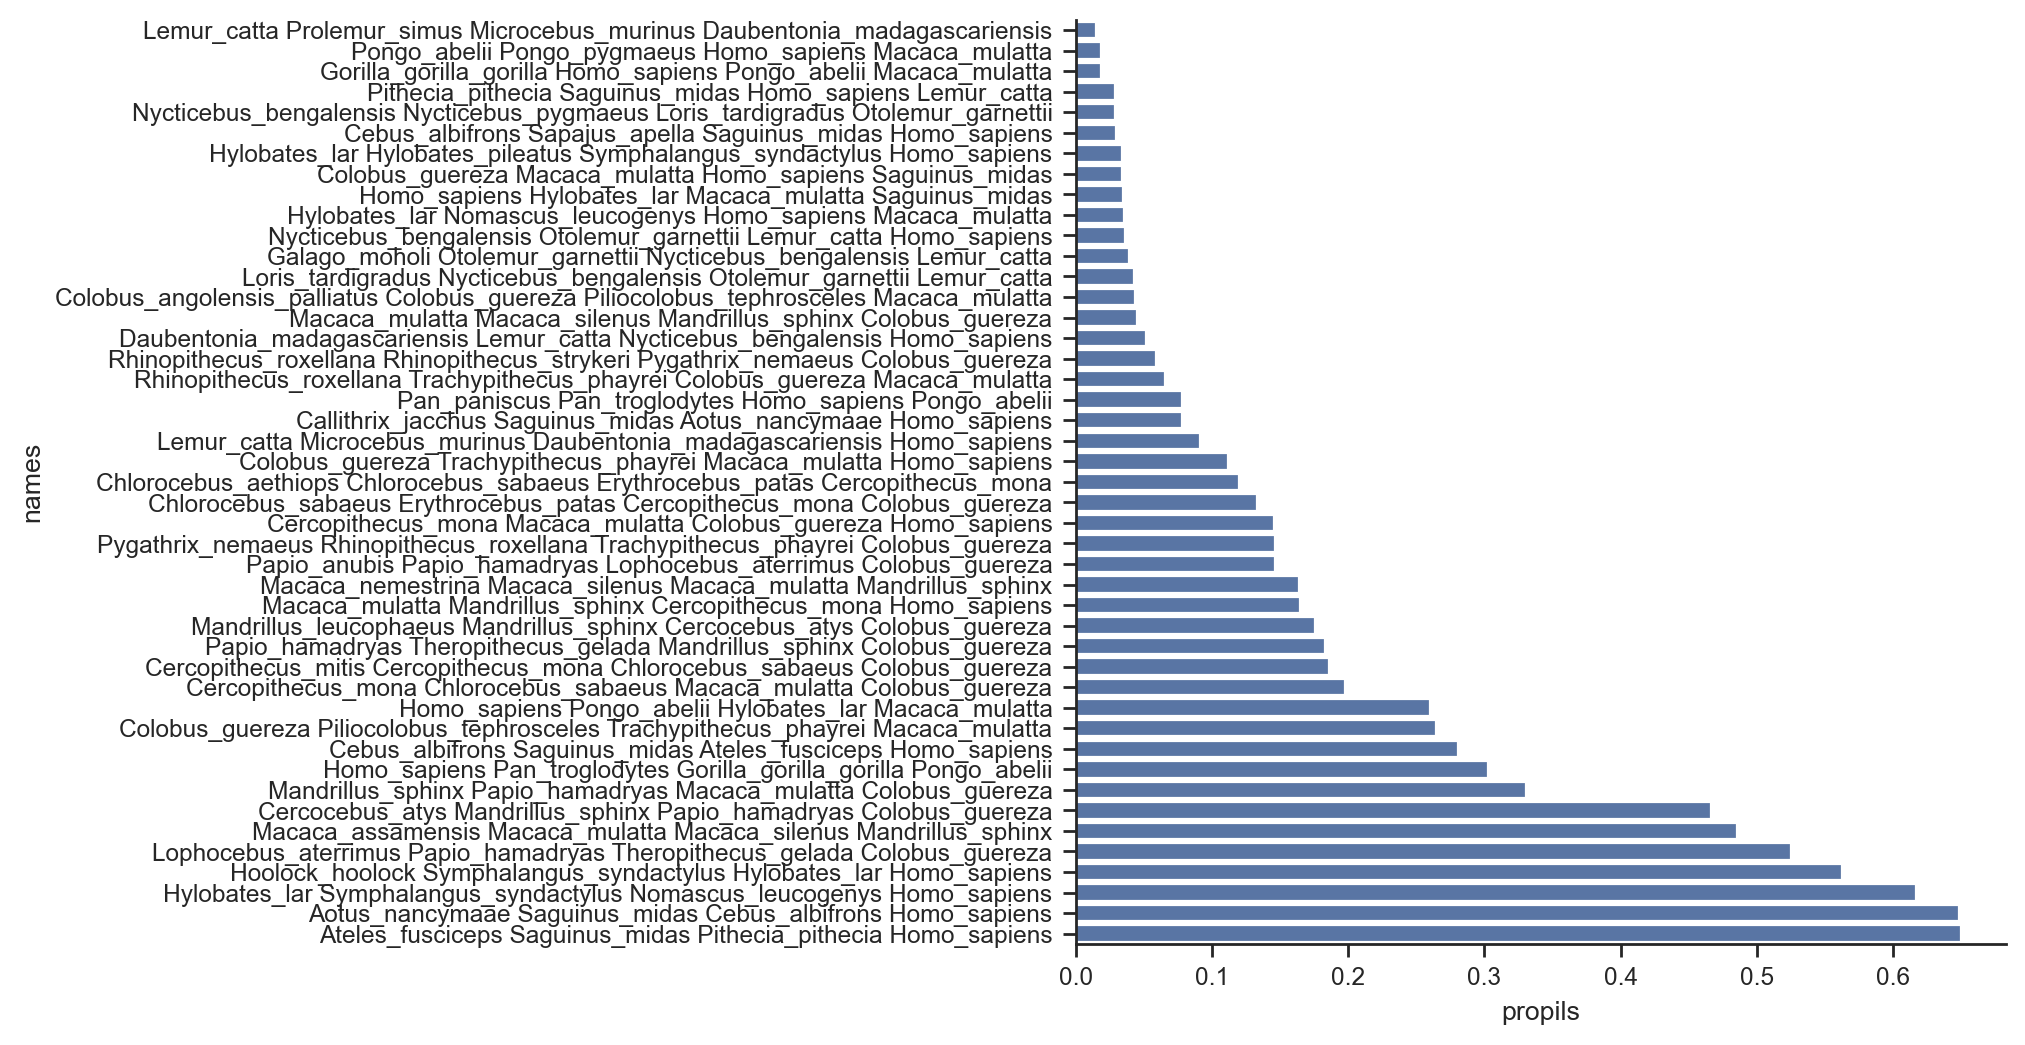

In [71]:
global_mean_ils = ils_data.groupby(['analysis', 'names']).propils.mean().sort_values().to_frame().reset_index()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.barplot(x='propils', y='names', data=global_mean_ils, color='b', ax=ax)
sns.despine()

## Global ILS skew in each species

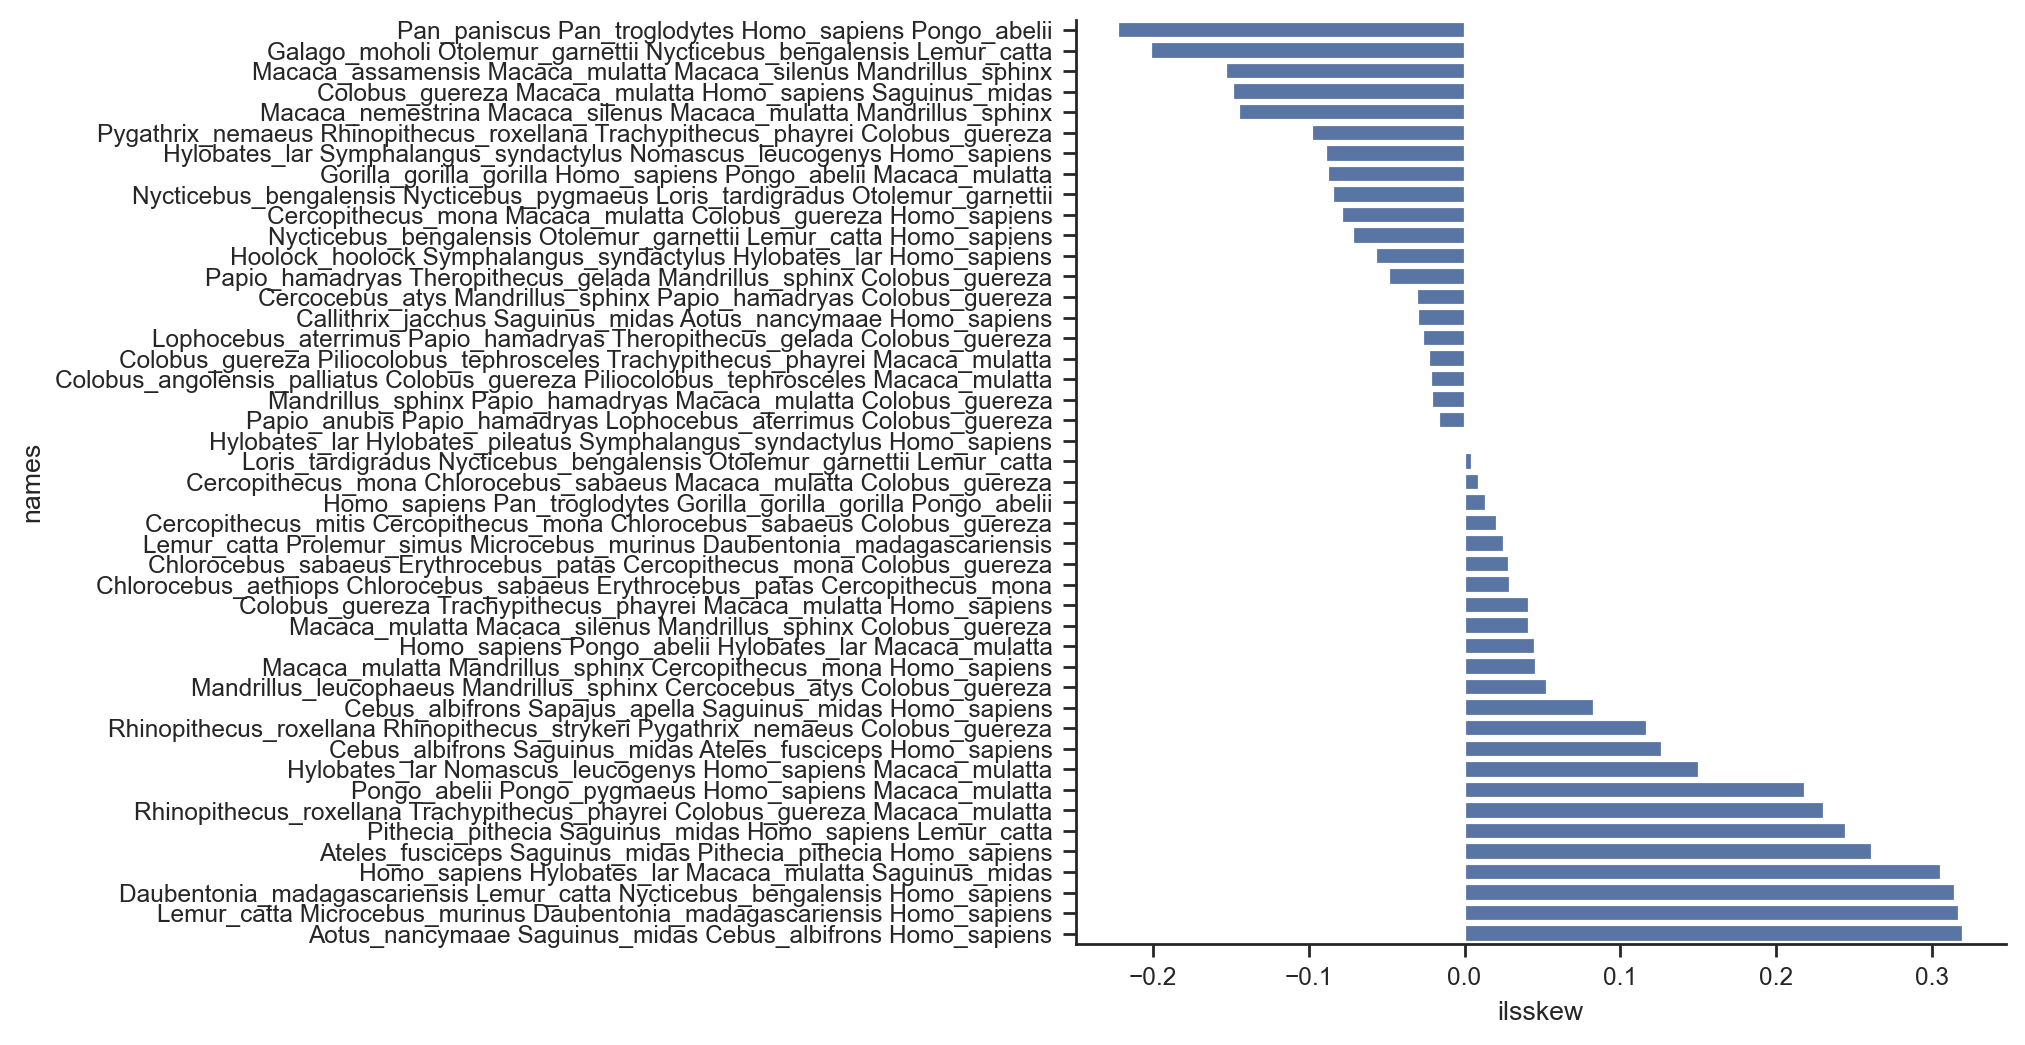

In [72]:
global_mean_skew = ils_data.groupby(['analysis', 'names']).ilsskew.mean().sort_values().to_frame().reset_index()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.barplot(x='ilsskew', y='names', data=global_mean_skew, color='b', ax=ax)
sns.despine()